In [1]:
#for data manipulations
import pandas as pd
import numpy as np

#No warnings about setting value on copy of slice
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns',60)

#for viazualiztion
import matplotlib.pyplot as plt
%matplotlib inline

#set default font size
plt.rcParams['font.size'] = 24

from IPython.core.pylabtools import figsize

#for visualization
import seaborn as sns
sns.set(font_scale=2)

#imputting missing values and scaling values
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer

#machine learning models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor,\
    GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

#hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV,\
    GridSearchCV

Read in Data

In [2]:
#read in data into dataframes
train_features = pd.read_csv('data/training_features.csv')
test_features = pd.read_csv('data/testing_features.csv')
train_labels = pd.read_csv('data/training_labels.csv')
test_labels = pd.read_csv('data/testing_labels.csv')

#display sizes of data
print('Training feature size : ',train_features.shape)
print('Training labels size : ',train_labels.shape)
print('Testing feature size : ',test_features.shape)
print('Testing labels size : ',test_labels.shape)


Training feature size :  (6622, 64)
Training labels size :  (6622, 1)
Testing feature size :  (2839, 64)
Testing labels size :  (2839, 1)


In [3]:
train_features.head(12)

,Order,Property Id,DOF Gross Floor Area,Year Built,Number of Buildings - Self-reported,Occupancy,Site EUI (kBtu/ft²),Weather Normalized Site Electricity Intensity (kWh/ft²),Weather Normalized Site Natural Gas Intensity (therms/ft²),Latitude,Longitude,Community Board,Census Tract,logDirect GHG Emissions (Metric Tons CO2e),logWater Use (All Water Sources) (kgal),logWater Intensity (All Water Sources) (gal/ft²),Borough_Staten Island,Largest Property Use Type_Adult Education,Largest Property Use Type_Automobile Dealership,Largest Property Use Type_Bank Branch,Largest Property Use Type_College/University,Largest Property Use Type_Convenience Store without Gas Station,Largest Property Use Type_Courthouse,Largest Property Use Type_Distribution Center,Largest Property Use Type_Enclosed Mall,Largest Property Use Type_Financial Office,Largest Property Use Type_Hospital (General Medical & Surgical),Largest Property Use Type_Hotel,Largest Property Use Type_K-12 School,Largest Property Use Type_Library,...,Largest Property Use Type_Multifamily Housing,Largest Property Use Type_Museum,Largest Property Use Type_Non-Refrigerated Warehouse,Largest Property Use Type_Other,Largest Property Use Type_Other - Education,Largest Property Use Type_Other - Entertainment/Public Assembly,Largest Property Use Type_Other - Lodging/Residential,Largest Property Use Type_Other - Mall,Largest Property Use Type_Other - Public Services,Largest Property Use Type_Other - Recreation,Largest Property Use Type_Other - Services,Largest Property Use Type_Other - Specialty Hospital,Largest Property Use Type_Outpatient Rehabilitation/Physical Therapy,Largest Property Use Type_Parking,Largest Property Use Type_Performing Arts,Largest Property Use Type_Pre-school/Daycare,Largest Property Use Type_Refrigerated Warehouse,"Largest Property Use Type_Repair Services (Vehicle, Shoe, Locksmith, etc.)",Largest Property Use Type_Residence Hall/Dormitory,Largest Property Use Type_Residential Care Facility,Largest Property Use Type_Restaurant,Largest Property Use Type_Retail Store,Largest Property Use Type_Self-Storage Facility,Largest Property Use Type_Senior Care Community,Largest Property Use Type_Social/Meeting Hall,Largest Property Use Type_Strip Mall,Largest Property Use Type_Supermarket/Grocery Store,Largest Property Use Type_Urgent Care/Clinic/Other Outpatient,Largest Property Use Type_Wholesale Club/Supercenter,Largest Property Use Type_Worship Facility
0,13276,5849784,90300.0,1950,1,100,126.0,5.2,1.2,NaN,NaN,NaN,NaN,6.088818,8.946987,4.599253,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,7377,4398442,52000.0,1926,1,100,95.4,4.7,0.9,40.835496,-73.887745,3.0,161.0,5.384036,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,9479,4665374,104700.0,1954,1,100,40.4,3.8,0.3,40.663206,-73.949469,9.0,329.0,5.017280,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,14774,3393340,129333.0,1992,1,100,157.1,16.9,1.1,40.622968,-74.078742,1.0,27.0,6.510853,NaN,NaN,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,3286,2704325,109896.0,1927,1,100,62.3,3.5,0.0,40.782421,-73.972622,7.0,165.0,6.123589,8.158774,3.355153,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,1060,2430725,182655.0,1929,1,90,52.9,9.7,0.2,40.725136,-74.004438,2.0,37.0,5.516649,7.059618,1.568616,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,10846,5737475,65400.0,1942,1,100,66.8,3.0,0.6,40.637833,-73.973045,12.0,490.0,5.426271,8.541437,4.206780,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,4280,2670505,113150.0,1938,1,100,78.4,5.7,NaN,40.776035,-73.964418,8.0,142.0,6.067036,8.127080,3.425239,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,12974,296

Text(0.5, 1.0, 'Energy Star Score Distribution')

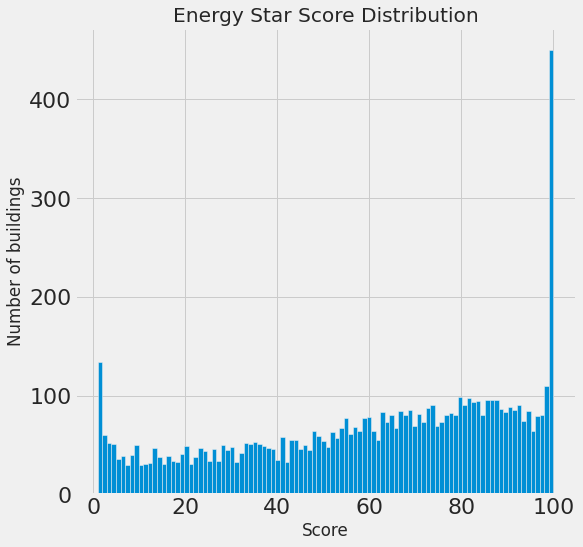

In [4]:
figsize(8,8)

#histogram of the Energy Star Score
plt.style.use('fivethirtyeight')
plt.hist(train_labels['score'].dropna(),bins=100)
plt.xlabel('Score')
plt.ylabel('Number of buildings')
plt.title('Energy Star Score Distribution')

We are comparing models using the mean absolute error.

Imputing missing values

In [5]:
#Create an imputer object with a median filling strategy
imputer = SimpleImputer(strategy='median')

#Train on the training features
imputer.fit(train_features)

#Transform both training data and testing data
X = imputer.transform(train_features)
X_test = imputer.transform(test_features)

In [6]:
print('Missing values in training set : ',np.sum(np.isnan(X)))
print('Missing values in testing set : ',np.sum(np.isnan(X_test)))

Missing values in training set :  0
Missing values in testing set :  0


In [7]:
#Make sure all values are finite
print(np.where(~np.isfinite(X)))
print(np.where(~np.isfinite(X_test)))

(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))


Scaling features

In [8]:
#Create a scaler object with range of 0-1
scaler = MinMaxScaler(feature_range=(0,1))

#Fit on the training data
scaler.fit(train_features)

# Transform both the training and testing data
X = scaler.transform(X)
X_test = scaler.transform(X_test)

In [9]:
# Convert y to one-dimensional array (vector)
y = np.array(train_labels).reshape((-1, ))
y_test = np.array(test_labels).reshape((-1, ))

In [10]:
# Function to calculate mean absolute error
def mae(y_true,y_pred):
    return np.mean(abs(y_true - y_pred))

# Takes in a model, trains the model, and evaluates the model
# on the test set
def fit_and_evaluate(model):
    # Train model
    model.fit(X,y)

    # Make predictions and evaluate
    model_pred = model.predict(X_test)
    model_mae = mae(y_test,model_pred)

    # Return the performance metric
    return  model_mae

In [11]:
lr = LinearRegression()
lr_mae = fit_and_evaluate(lr)
print('Linear Regression Performance on the test set : MAE = %0.4f ' % lr_mae)

Linear Regression Performance on the test set : MAE = 13.4664 


In [12]:
svm = SVR(C=1000,gamma=0.1)
svm_mae = fit_and_evaluate(svm)
print('Support Vector Machine Regression Performance on the test set : MAE = %0.4f' % svm_mae)

Support Vector Machine Regression Performance on the test set : MAE = 10.9182


In [13]:
random_forest = RandomForestRegressor()
random_forest_mae = fit_and_evaluate(random_forest)
print('Random Forest Regression Performance on the test set : MAE = %0.4f' % random_forest_mae)

Random Forest Regression Performance on the test set : MAE = 9.5347


In [14]:
gradient_boosted = GradientBoostingRegressor()
gradient_boosted_mae = fit_and_evaluate(gradient_boosted)
print('Gradient Boosted Regression  Performance on the test set : MAE = %0.4f' % gradient_boosted_mae)

Gradient Boosted Regression  Performance on the test set : MAE = 10.0100


In [15]:
knn = KNeighborsRegressor()
knn_mae = fit_and_evaluate(knn)
print('K-Nearest Neighbors Regression Performance on the test set: MAE = %0.4f' % knn_mae)

K-Nearest Neighbors Regression Performance on the test set: MAE = 12.7808


Text(0.5, 1.0, 'Model Comparison on the test MAE')

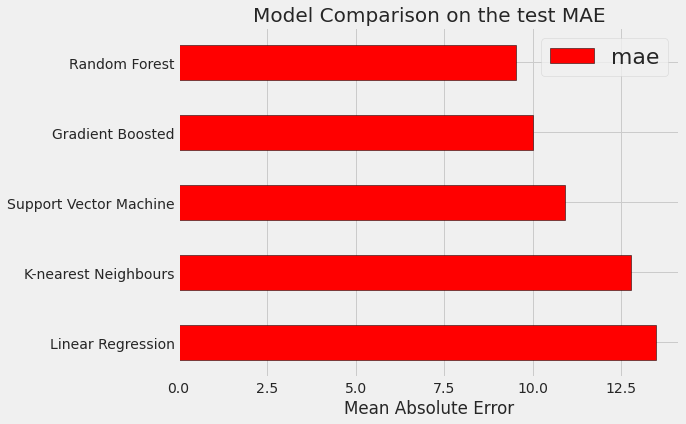

In [16]:
plt.style.use('fivethirtyeight')
figsize(8,6)

# Dataframe to hold the results
model_comparison = pd.DataFrame({
    'model' : [
        'Linear Regression',
        'Support Vector Machine',
        'Random Forest',
        'Gradient Boosted',
        'K-nearest Neighbours'
    ],
    'mae': [
        lr_mae,
        svm_mae,
        random_forest_mae,
        gradient_boosted_mae,
        knn_mae
    ]
})

# Horizontal bar chart of test mae
model_comparison.sort_values('mae',ascending=False).plot(
    x='model',
    y='mae',
    kind='barh',
    color='red',
    edgecolor='black'
)

# Plot formatting
plt.xlabel('Mean Absolute Error')
plt.xticks(size=14)

plt.ylabel('')
plt.yticks(size=14)

plt.title('Model Comparison on the test MAE',size=20)

Hyperparameter Tuning with Random Search and Cross Validation

In [17]:
# Loss function to be optimized
loss = ['ls','lad','huber']

# Number of trees using in the boosting process
n_estimators = [100,500,900,1100,1500]

# max depth of each tree
max_depth = [2,3,5,10,15]

# min number of samples per leaf
min_samples_leaf = [1,2,4,6,8]

# min number of samples to split a node
min_samples_split = [2,4,6,10]

# maximum number of features to consider for making splits
max_features = ['auto','sqrt','log2',None]

# define the grid pf hyperparameters to search
hyperparameter_grid = {
    'loss' : loss,
    'n_estimators' : n_estimators,
    'max_depth' : max_depth,
    'min_samples_leaf' : min_samples_leaf,
    'min_samples_split' : min_samples_split,
    'max_features' : max_features
}

In [18]:
#Create the model to use for hyperparameter tuning
model = GradientBoostingRegressor(random_state=42)

#Set up the random search with 4-fold cross validation

random_cv = RandomizedSearchCV(estimator=model,
                               param_distributions=hyperparameter_grid,
                               cv=4,
                               n_iter=25,
                               scoring='neg_mean_absolute_error',
                               n_jobs=-1,
                               verbose=1,
                               return_train_score=True,
                               random_state=42)

In [19]:
random_cv.fit(X,y)

Fitting 4 folds for each of 25 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 13.8min finished


RandomizedSearchCV(cv=4, estimator=GradientBoostingRegressor(random_state=42),
                   n_iter=25, n_jobs=-1,
                   param_distributions={'loss': ['ls', 'lad', 'huber'],
                                        'max_depth': [2, 3, 5, 10, 15],
                                        'max_features': ['auto', 'sqrt', 'log2',
                                                         None],
                                        'min_samples_leaf': [1, 2, 4, 6, 8],
                                        'min_samples_split': [2, 4, 6, 10],
                                        'n_estimators': [100, 500, 900, 1100,
                                                         1500]},
                   random_state=42, return_train_score=True,
                   scoring='neg_mean_absolute_error', verbose=1)

Scikit-learn uses the negative mean absolute error for evaluation because it wants a metric to maximize.
Therefore, a better score will be closer to 0. We can get the results of the randomized search into a dataframe,
and sort the values by performance.

In [20]:
# Get all of the cv results and sort by the test performance
random_results = pd.DataFrame(random_cv.cv_results_).sort_values('mean_test_score',ascending=False)

random_results.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_loss,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
12,44.840192,1.344585,0.044593,0.007895,500,6,6,None,5,lad,"{'n_estimators': 500, 'min_samples_split': 6, ...",-8.812091,-8.785506,-9.310755,-9.036036,-8.986097,0.211194,1,-7.184102,-6.957174,-6.715166,-6.844052,-6.925124,0.172302
3,47.310946,0.388561,0.038395,0.001160,500,6,8,None,5,huber,"{'n_estimators': 500, 'min_samples_split': 6, ...",-8.890596,-8.898031,-9.296314,-9.130954,-9.053974,0.170048,2,-4.380035,-4.239261,-4.746020,-4.141776,-4.376773,0.229394
9,28.645468,0.642483,0.033592,0.007344,500,4,2,auto,3,huber,"{'n_estimators': 500, 'min_samples_split': 4, ...",-9.080094,-8.975553,-9.416348,-9.143534,-9.153882,0.162973,3,-6.974922,-7.072712,-6.894873,-6.887053,-6.957390,0.074937
0,8.907346,0.360031,0.017411,0.009068,100,2,6,auto,5,ls,"{'n_estimators': 100, 'min_samples_split': 2, ...",-9.022607,-8.999637,-9.470742,-9.220944,-9.178482,0.189408,4,-7.302349,-7.267157,-7.168693,-7.327726,-7.266481,0.060416
7,29.654505,0.562738,0.035362,0.005639,500,4,6,auto,3,ls,"{'n_estimators': 500, 'min_samples_split': 4, ...",-9.138314,-9.124772,-9.597564,-9.390770,-9.312855,0.195557,5,-7.087413,-7.059133,-6.905369,-7.019402,-7.017829,0.069278
10,201.086714,1.225411,0.167570,0.018888,1100,10,6,None,10,huber,"{'n_estimators': 1100, 'min_samples_split': 10...",-9.249455,-9.137472,-9.560898,-9.450072,-9.349474,0.165657,6,-0.382832,-0.435709,-0.381710,-0.368007,-0.392065,0.025865
21,8.626279,0.119951,0.041810,0.004211,500,6,4,log2,5,huber,"{'n_estimators': 500, 'min_samples_split': 6, ...",-9.370712,-9.209711,-9.719853,-9.267836,-9.392028,0.197855,7,-5.647560,-5.769221,-5.650796,-5.656253,-5.680958,0.051053
16,72.695537,0.996510,0.079382,0.003139,1500,4,6,None,3,ls,"{'n_estimators': 1500, 'min_samples_split': 4,...",-9.223841,-9.270521,-9.759087,-9.416631,-9.417520,0.209636,8,-4.795235,-4.777664,-4.706972,-4.630265,-4.727534,0.065154
2,118.153582,1.923616,0.111204,0.032494,500,4,2,auto,10,huber,"{'n_estimators': 500, 'min_samples_split': 4, ...",-9.521627,-9.251241,-9.515120,-9.459067,-9.436764,0.109838,9,-0.166622,-0.164578,-0.127714,-0.133663,-0.148144,0.017597
22,66.966561,1.381636,0.054483,0.009690,1500,2,8,None,5,ls,"{'n_estimators': 1500, 'min_samples_split': 2,...",-9.330458,-9.318695,-9.617578,-9.500073,-9.441701,0.124344,10,-1.595882,-1.467899,-1.545691,-1.502826,-1.528075,0.047871


In [21]:
random_cv.best_estimator_

GradientBoostingRegressor(loss='lad', max_depth=5, min_samples_leaf=6,
                          min_samples_split=6, n_estimators=500,
                          random_state=42)

In [22]:
# Create a range of trees to evaluate
trees_grid = {'n_estimators':[100,150,200,250,300,350,400,450,500,550,600,650,700,750,800]}

model = GradientBoostingRegressor(loss='lad',
                                  max_depth=5,
                                  min_samples_leaf=6,
                                  min_samples_split=6,
                                  max_features=None,
                                  random_state=42)

# Grid Search Object using the trees range and the random forest model
grid_search = GridSearchCV(estimator=model,
                           param_grid=trees_grid,
                           cv=4,
                           scoring='neg_mean_absolute_error',
                           verbose=1,
                           n_jobs=-1,
                           return_train_score=True)

In [23]:
# Fit the grid search
grid_search.fit(X,y)


Fitting 4 folds for each of 15 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  4.0min finished


GridSearchCV(cv=4,
             estimator=GradientBoostingRegressor(loss='lad', max_depth=5,
                                                 min_samples_leaf=6,
                                                 min_samples_split=6,
                                                 random_state=42),
             n_jobs=-1,
             param_grid={'n_estimators': [100, 150, 200, 250, 300, 350, 400,
                                          450, 500, 550, 600, 650, 700, 750,
                                          800]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

Text(0.5, 1.0, 'Performance vs Number of Trees')

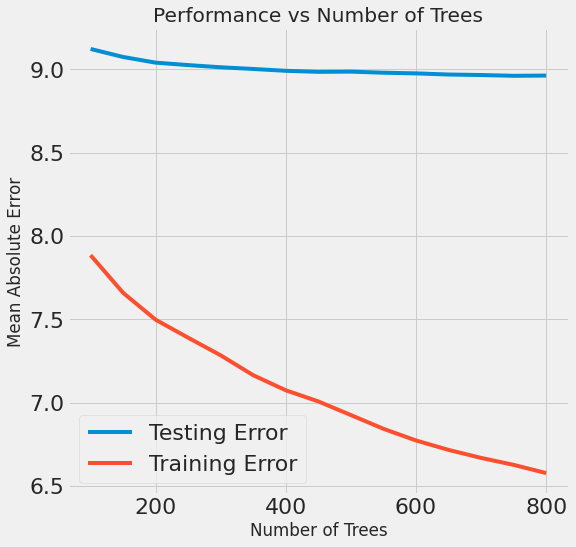

In [24]:
# Get the results into a dataframe

results = pd.DataFrame(grid_search.cv_results_)

# Plot the training and testing error vs number of trees

figsize(8,8)
plt.style.use('fivethirtyeight')
plt.plot(results['param_n_estimators'],
         -1 * results['mean_test_score'],
         label='Testing Error')
plt.plot(results['param_n_estimators'],
         -1 * results['mean_train_score'],
         label='Training Error')
plt.xlabel('Number of Trees')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.title('Performance vs Number of Trees')

In [25]:
results.sort_values('mean_test_score',ascending=False).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
13,51.958262,0.754791,0.048353,0.003266,750,{'n_estimators': 750},-8.775462,-8.735820,-9.313667,-9.019150,-8.961025,0.230697,1,-6.932274,-6.672606,-6.401492,-6.499500,-6.626468,0.201483
14,42.673680,0.535121,0.026895,0.004199,800,{'n_estimators': 800},-8.781172,-8.729637,-9.311934,-9.026826,-8.962392,0.230947,2,-6.892295,-6.631553,-6.353126,-6.431173,-6.577037,0.208430
12,48.891785,0.181451,0.045438,0.000810,700,{'n_estimators': 700},-8.783996,-8.750403,-9.312663,-9.015845,-8.965726,0.224870,3,-6.977757,-6.723073,-6.437409,-6.534392,-6.668158,0.206159
11,45.492601,0.752841,0.043802,0.001811,650,{'n_estimators': 650},-8.786230,-8.753152,-9.314404,-9.020806,-8.968648,0.224712,4,-7.011676,-6.767009,-6.486932,-6.599127,-6.716186,0.197584
10,42.423291,0.244619,0.041461,0.000612,600,{'n_estimators': 600},-8.792397,-8.766493,-9.317047,-9.026209,-8.975537,0.221606,5,-7.043055,-6.815262,-6.560984,-6.671682,-6.772746,0.180230


In [26]:
# Default model
default_model = GradientBoostingRegressor(random_state=42)

# Select the best model
final_model = grid_search.best_estimator_

final_model

GradientBoostingRegressor(loss='lad', max_depth=5, min_samples_leaf=6,
                          min_samples_split=6, n_estimators=750,
                          random_state=42)

In [27]:
%%timeit -n 1 -r 5
default_model.fit(X,y)

1.89 s ± 135 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


In [28]:
%%timeit -n 1 -r 5
final_model.fit(X,y)

25.7 s ± 602 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


In [29]:
default_pred = default_model.predict(X_test)
final_pred = final_model.predict(X_test)

print('Default model performance on the test set : MAE = %0.4f' % mae(y_test,default_pred))
print('Final model performance on the test set : MAE = %0.4f' % mae(y_test,final_pred))


Default model performance on the test set : MAE = 10.0097
Final model performance on the test set : MAE = 9.0816


Text(0.5, 1.0, 'Test Values and Predictions')

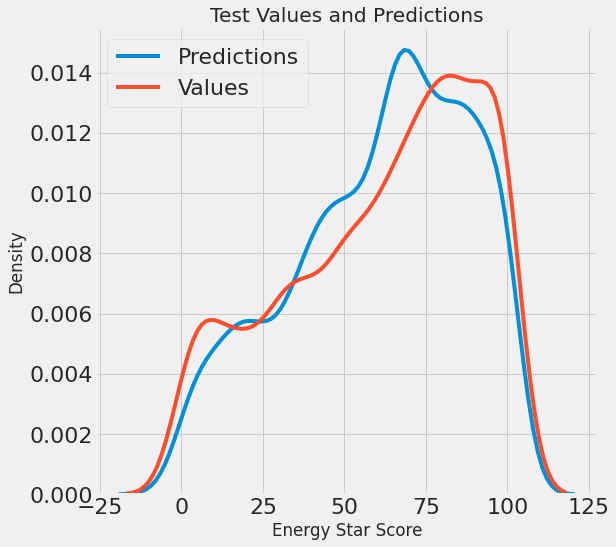

In [30]:
figsize(8,8)

# Density plot of the final predictions and the test values
sns.kdeplot(final_pred,label='Predictions')
sns.kdeplot(y_test,label='Values')

# Label the plot
plt.xlabel('Energy Star Score')
plt.ylabel('Density')
plt.title('Test Values and Predictions')

Text(0.5, 1.0, 'Distribution of Residuals')

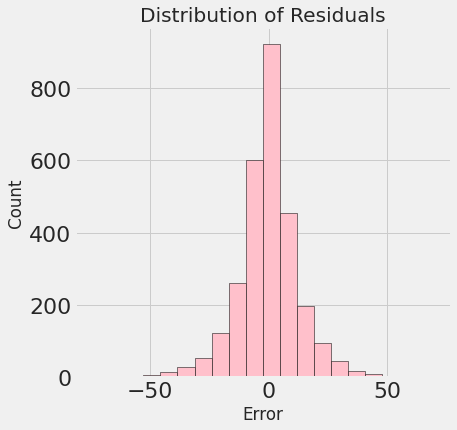

In [32]:
figsize(6,6)

# Calculate the residuals
residuals = final_pred - y_test

# Plot the residuals in the histogram
plt.hist(residuals,color='pink',bins=20,edgecolor='black')
plt.xlabel('Error')
plt.ylabel('Count')
plt.title('Distribution of Residuals')
